In [1]:
# Make Jupyter Notebook full screen # Optional of course

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import things you need: (might not need all in this code, copy and paste for whole project)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import plotly.express as px
from chart_studio.plotly import plot as py
import os
import math
import csv
from datetime import datetime
from datetime import timedelta
import random
import time
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

In [3]:
# Set your matplotlib settings to call later, these are the ones I like... 


%matplotlib inline

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 18}

plt.rc('font', **font) #Set this one as the defult, change to 1 or 2 in the plotting code cell

font1 = {'family': 'serif', 'weight': 'bold', 'size': 20, }
font2 = {'family': 'serif', 'weight': 'normal', 'size': 16, }

In [4]:
# import the shape files of Madison 

city = geopandas.read_file("City")
lakes = geopandas.read_file("Lakes")
Street = geopandas.read_file("Street")

In [6]:
# Took this conversion from online calculator, 3 mile pace is from wikipedia

DegLat = 6.903*10 # miles
DegLon = 10.125 * 5 #miles
pace = 3 # MPH 

In [7]:
# Define a couple helpful to have functions

def getListsOfPoints(dictionary, listName):
    for key in dictionary:
        listName.append(dictionary[key])
        
def getDistance(xa, ya, xb, yb): 
    distance = np.sqrt(((xb-xa)**2)+(yb-ya)**2)
    return distance

def DistanceBetweenPoints(distance):
    LatVariance =  distance / DegLat
    LonVariance =  distance / DegLon
    Variance = [LatVariance, LonVariance]
    return Variance

#Get distance between two points from lat and lon
def MilesDistanceFromGlobePoints(xa, ya, xb, yb):
    xa =  xa * DegLat
    xb =  xb * DegLat
    ya =  ya * DegLon
    yb =  yb * DegLon
    distance = np.sqrt(((xb-xa)**2)+(yb-ya)**2)
    return distance

In [8]:
# Pull in the JSON files from the parsing notebook 

with open('routesStopsTryAgain.json', 'r') as myfile:
    data=myfile.read()
routesStopsTryAgain = json.loads(data)

with open('stopIDLookUp.json', 'r') as myfile:
    data=myfile.read()
stopIDLookUp = json.loads(data)

with open('stopIDLookUpBRT.json', 'r') as myfile:
    data=myfile.read()
stopIDLookUpBRT = json.loads(data)

In [27]:
# Remind yourself how these look:
print(stopIDLookUpBRT['23'])
print(stopIDLookUp['9520'])

[43.12643795, -89.30702593]
[43.131605, -89.30345600000001]


In [28]:
tripsData = pd.read_csv('mmt_gtfs/trips.txt', sep=",")

# tripsDataRouteSpec = tripsData[tripsData.route_short_name == 37]
# tripsDataRouteSpec = tripsData[tripsData.service_id == '87_WKD']
# #tripsDataRouteSpec

In [29]:
stopTimesData = pd.read_csv('mmt_gtfs/stop_times.txt', sep=",")

# stopsTimeData = stopTimesData[stopTimesData.trip_id == 894620]
# #stopsTimeData

In [30]:
# stopsTimeData = stopTimesData[stopTimesData.trip_id == 901168]
# #stopsTimeData

## getBusRouteZeroTransfersFarthestPoint:

- Input a starting stop number, and find the farthest distance that you can go with zero transfers. 

- does not take into account BRT. 
- Does take into account time of day you want to travel. Considers any route that stops at your stop +- 30 minutes from when you get there, you can change this in the code to be 15 min, 5 min, etc. But it just compared the time difference from the time that you input to the function and when a route has a possible stop there. 
- Need to give it a ride key

In [31]:
# These times show up and can cause problems: There are many more too, but be aware. 
# badTimes = ['24:04:00', '24:00:00', '24:23:00', '24:09:00', '24:39:00', '24:13:00', '24:18:00', '24:03:00', '24:21:25', '24:02:57', '24:09:37']

def getBusRouteZeroTransfersFarthestPoint(start, RideKey, startTime): # Ridekey = 87_WKD for now
    
    StartBusRoutes = []
    
    #Find the routes that have this stop as an option for them to stop at

    for i in routesStopsTryAgain:
        if start in routesStopsTryAgain[i]:
            StartBusRoutes.append(i)
    #print(StartBusRoutes)
    
    # Get the dataframe list for these routes
    possibleTrips = []
    for i in StartBusRoutes:
        if 1 > 0:   # I hate untabbing things, to yea, this is true... 
            #print(i)
            tripsDataStart = tripsData[tripsData.route_short_name == int(i)]
            tripsDataStart = tripsDataStart[tripsDataStart.service_id == RideKey]
        
            for j in tripsDataStart.iterrows():
                tripID = j[1]['trip_id']
                stopsTimeData = stopTimesData[stopTimesData.trip_id == tripID]
            
                for n in stopsTimeData.iterrows():
                    if n[1]['stop_id'] == start:
                        #if n[1]['arrival_time'] in badTimes:
                            #continue
                        # There are bad entries for times like in the list given above, just skip these instances
                        try:
                            datetime_objectRoute = datetime.strptime(n[1]['arrival_time'], '%H:%M:%S')
                        except ValueError:
                            continue
                        #print(datetime_objectRoute)
                        datetime_objectStart = datetime.strptime(startTime, '%H:%M:%S')
                        timeDelta = abs(datetime_objectStart - datetime_objectRoute) #I am timedelta object
                        if timeDelta.seconds < (30*60):
                            timeDelta
                            possibleTrips.append(tripID)
    #print(possibleTrips)
    
    #Now we have a list of possible trips, need to find the farthest distance to go in each trip and then the farthest of those possibilities
    farthestPoint = [0.0]
    for trip in possibleTrips:
        stopTimesDataSpec = stopTimesData[stopTimesData.trip_id == int(trip)]
        for stop in stopTimesDataSpec.iterrows():
            startingPoint = stopIDLookUp[str(start)]
            endingStop = stop[1]['stop_id']
            endingPoint = stopIDLookUp[str(endingStop)]
            distanceMiles = MilesDistanceFromGlobePoints(startingPoint[0], startingPoint[1], endingPoint[0], endingPoint[1])
            if distanceMiles > farthestPoint[0]:
                farthestPoint[0] = distanceMiles
    #print(farthestPoint)
    return farthestPoint[0]

# I am example formatting and an example run that will work for testing: 
getBusRouteZeroTransfersFarthestPoint(4100, '87_WKD', '8:20:00')

5.541214152566777

### Define the routes that you want to consider, if you want to do them all, you could make a list here of all the routes, or hope that Megan has uploaded a different code that does them all already to the repo...

### Then make a list of all the stops that those routes use. This is a little meh in here, b/c not all routes use all these stops during the day, but that will be accounted for in the time aspect of the code above, but you could get some zeros in the distances dictionary if the bus doesnt actually stop at those stops for the time you chose. 

In [33]:
Routes = ['6', '30', '34', '36']
StopsIn6303436 = []

for i in routesStopsTryAgain:
    if str(i) in Routes:
        for j in routesStopsTryAgain[i]:
            if j not in StopsIn6303436:
                StopsIn6303436.append(j)

# This is a poor man's progress bar. Here are the total number of stops, the next cell will print a counter that you can compare to know how long its taking to run
print(len(StopsIn6303436))

280


In [36]:
# Now get a dictionary of the farthest distance for ALL the stops in the specified route. Print a counter for each loop you run. 

def getDictionaryFarthestStopsALLRoutes(startTime):
    dictionary = {}
    j=0
    for i in StopsIn6303436:
        #print(i)
        farthestPoint = getBusRouteZeroTransfersFarthestPoint(int(i), '87_WKD', startTime)
        #print(farthestPoint)
        if farthestPoint == 0:
            continue
        else:
            dictionary[i] = farthestPoint
        j += 1
        print(j)
    return dictionary
        
# Save it as a dictionary locally, b/c this takes FOREVER to run. When doing the project for real and once I know that I am computing the real thing that 
# I want to, I usually just save this as a JSON to my computer and read it in again, so that I only ever have to do it once, and can just read the same file in 
# months down the road...
DictionaryFarthestStopsALLRoutes8am = getDictionaryFarthestStopsALLRoutes('8:00:00')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


In [37]:
# Make other dictionaries... 
#DictionaryFarthestStopsALLRoutes12PM = getDictionaryFarthestStopsALLRoutes('12:00:00') 

In [40]:
# Idk why... must've been useful for something
len(stopIDLookUp)

2192

In [46]:
# You can look up these stops on metro and google maps and check that you are doing things right: https://www.cityofmadison.com/metro/stops

DictionaryFarthestStopsALLRoutes8am

{6100: 10.702967442594822,
 2939: 9.695080092946327,
 2323: 9.501791163762745,
 2417: 9.404531683844342,
 2161: 9.194861491890153,
 2615: 9.038216798533671,
 2111: 8.854327687389073,
 2233: 8.725866129894074,
 2431: 8.605865073319942,
 2889: 8.47262623469223,
 2387: 8.380920038360664,
 2435: 8.315377086697593,
 2937: 8.250418504769607,
 2737: 9.036960571494797,
 2659: 8.88112755464827,
 2231: 8.74806336805154,
 2137: 8.573830367372992,
 2377: 8.183498402672905,
 2773: 8.116034684047825,
 2899: 8.011598105367277,
 2949: 7.913274118567915,
 2691: 7.742479956049313,
 533: 7.631411949448206,
 971: 7.473340701778919,
 583: 7.412794750580593,
 327: 7.274241744284614,
 115: 7.149018194991602,
 483: 7.087017856890729,
 561: 7.009131405210984,
 455: 6.935146689953855,
 765: 6.779124348608102,
 265: 6.683887003870501,
 505: 6.569724959135014,
 549: 6.510707119393755,
 803: 6.450126342977847,
 883: 7.429058074415515,
 1324: 10.470240855851209,
 1101: 10.534004018761388,
 1787: 10.658649038337826,

## Making the Discritized Heat map:

In [41]:
# --- Define the lat and lon min and max for the map --- 
# This will depend on what routes you include. 
latMin = 43.04
latMax = 43.150
lonMin = -89.49
lonMax = -89.28


# --- Set the grid size for the discritization --- 

# Assume 3 MPH walking pace: 

DegLat = 6.903*10 # miles
DegLon = 10.125 * 5 #miles


# Set teh size of your boxes, I prefer 5 min boxes personally for most maps. 

LatitudeDistanceSteps =   .25/DegLat     # 5 min = .25 miles
LongitudeDistanceSteps =  .25/DegLon

# LatitudeDistanceSteps =   .5/DegLat     # 10 min = .5 miles
# LongitudeDistanceSteps =  .5/DegLon

# # This is where computer starts getting mad... shouldn't spec a new computer before you understand how much computation you will be doing on it... 
# LatitudeDistanceSteps =   .125/DegLat     # 2.5 min = .125 miles
# LongitudeDistanceSteps =  .125/DegLon

In [42]:
# Discritize the map of madison into the box size that you set above
# version 2 - more simple

DiscritizeDict = {}

def discritize(Latdivision, Londivision):
    
    latSteps = Latdivision
    lonSteps = Londivision
    x = 1
    y = 1
    latPoint = latMin
    lonPoint = lonMin
    
    for y in range(int((latMax - latMin)/latSteps)):
        lonPoint = lonMin
        for x in range(int((lonMax - lonMin)/lonSteps)):
            coordStr =  str(y) +"_" + str(x)
            DiscritizeDict[coordStr] = [latPoint, lonPoint]
            x += 1
            lonPoint += lonSteps
            
        y += 1
        x = 1
        latPoint += latSteps       
    
discritize(LatitudeDistanceSteps, LongitudeDistanceSteps)

In [43]:
# Create a list of the grid squares so that you can find which square the stops fall into. 

gridList = {}

def grid(Latdivision, Londivision):
    
    latSteps = Latdivision
    lonSteps = Londivision
    x = 1
    y = 1
    latPoint = latMin
    lonPoint = lonMin
    n = 1
    
    for y in range(int((latMax - latMin)/latSteps)):
        lonPoint = lonMin
        for x in range(int((lonMax - lonMin)/lonSteps)):
            Num =  str(n)
            gridList[Num] = [[latPoint, latPoint + latSteps] , [lonPoint, lonPoint+lonSteps]]
            x += 1
            lonPoint += lonSteps
            n += 1
            
        y += 1
        x = 1
        latPoint += latSteps       
    
#discritize(.01, .03)
grid(LatitudeDistanceSteps, LongitudeDistanceSteps)

gridList

{'1': [[43.04, 43.0436216137911], [-89.49, -89.48506172839505]],
 '2': [[43.04, 43.0436216137911], [-89.48506172839505, -89.48012345679011]],
 '3': [[43.04, 43.0436216137911], [-89.48012345679011, -89.47518518518517]],
 '4': [[43.04, 43.0436216137911], [-89.47518518518517, -89.47024691358023]],
 '5': [[43.04, 43.0436216137911], [-89.47024691358023, -89.46530864197528]],
 '6': [[43.04, 43.0436216137911], [-89.46530864197528, -89.46037037037034]],
 '7': [[43.04, 43.0436216137911], [-89.46037037037034, -89.4554320987654]],
 '8': [[43.04, 43.0436216137911], [-89.4554320987654, -89.45049382716046]],
 '9': [[43.04, 43.0436216137911], [-89.45049382716046, -89.44555555555552]],
 '10': [[43.04, 43.0436216137911], [-89.44555555555552, -89.44061728395057]],
 '11': [[43.04, 43.0436216137911], [-89.44061728395057, -89.43567901234563]],
 '12': [[43.04, 43.0436216137911], [-89.43567901234563, -89.43074074074069]],
 '13': [[43.04, 43.0436216137911], [-89.43074074074069, -89.42580246913575]],
 '14': [[

In [47]:
# Find the max distance from the distance dictionary to be able to set a good color scale
maxIm = [0.0]
for key in DictionaryFarthestStopsALLRoutes8am:
    value = DictionaryFarthestStopsALLRoutes8am[key]
    if value > maxIm[0]:
        maxIm[0] = value
    else:
        continue
maxIm 

[10.77772713268678]

In [45]:
# Go through each grid square and make a list of the farthest distances in each square by looking at which stops are in each square
#     --- Discritized Heat Map for given dictionary ---     #

def getDiscritizedHeatMap(dictionary): 
    DictOfRoutes = dictionary
    DiscritizedHeatMapSpecial = {}
    
    for i in DictOfRoutes:
        #if len(DictOfRoutes[i]) == 0:
            #continue
        avg = DictOfRoutes[i] #I AM NOT ACTUALLY THE AVERAGE, but I could be in other versions of this code
        for key in gridList:
            i = str(i)
            if (stopIDLookUp[i][0] > gridList[key][0][0]) and (stopIDLookUp[i][0] < gridList[key][0][1]):
                if (stopIDLookUp[i][1] > gridList[key][1][0]) and (stopIDLookUp[i][1] < gridList[key][1][1]):
                    if key not in DiscritizedHeatMapSpecial:
                        DiscritizedHeatMapSpecial[key] = []
                        DiscritizedHeatMapSpecial[key].append(avg)
                    else:
                        DiscritizedHeatMapSpecial[key].append(avg) 
                else: 
                    continue
            else:
                continue
                
    return DiscritizedHeatMapSpecial

In [49]:
# Get the dictionary save locally. This doesnt take long to run, so dont need to save into file like other one. 
DiscritizedHeatMap8am = getDiscritizedHeatMap(DictionaryFarthestStopsALLRoutes8am)

#Print it out, looks reasonable. 
DiscritizedHeatMap8am

{'130': [10.702967442594822, 9.695080092946327, 10.510555608211973],
 '131': [9.501791163762745, 10.32257956921033],
 '132': [9.404531683844342, 10.242887845081391],
 '133': [9.194861491890153, 10.020327284587825],
 '134': [9.038216798533671,
  8.854327687389073,
  9.75072772538207,
  9.870692860628415],
 '135': [8.725866129894074, 9.595086996397596],
 '136': [8.605865073319942,
  8.47262623469223,
  9.376452242055496,
  9.458977954569244],
 '178': [8.380920038360664,
  8.315377086697593,
  9.204821155576674,
  9.276525342830602],
 '220': [8.250418504769607,
  9.036960571494797,
  9.133374835189006,
  9.055239096803604,
  9.124447989117275,
  9.08321794548516,
  9.133449571378186],
 '221': [8.88112755464827, 8.917707192262112],
 '263': [8.74806336805154, 8.74230888688571],
 '264': [8.573830367372992, 8.584187971509369],
 '307': [8.183498402672905,
  8.116034684047825,
  8.136884601704642,
  8.278303730505678],
 '308': [8.011598105367277, 7.926762470747017, 8.047177799680565],
 '309': [

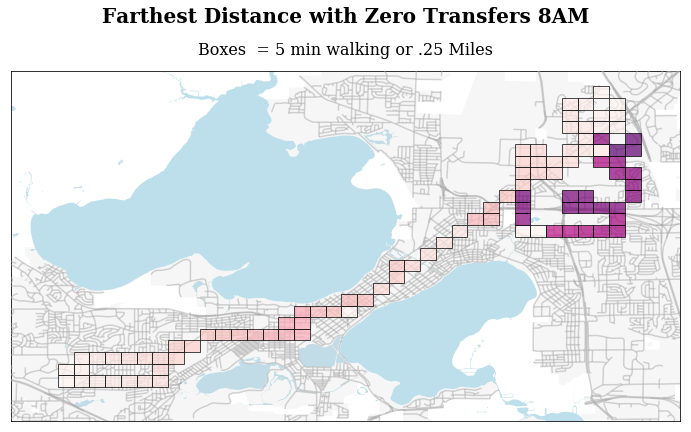

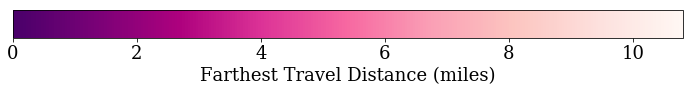

In [51]:
# This cell works. I try not to mess with it too much... 
# The color bar is a seperate plot so you cant save them together, I just screenshot... if someone fixed that it's be GREAT. 

HeatMapDict = DiscritizedHeatMap8am

Maximum = 10.8
max_value = 1000
viridis = cm.get_cmap('RdPu_r', max_value)

ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=.8)
Street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)

for key in HeatMapDict:
    #print(sum(HeatMapDict[key])/len(HeatMapDict[key]))
    colorVal = cm.RdPu_r(max(HeatMapDict[key])/Maximum)
    #print(colorVal)
    ax2 = plt.axvspan(gridList[key][1][0], gridList[key][1][1], ymin=((gridList[key][0][0]-latMin)/(latMax-latMin)), 
                     ymax=((gridList[key][0][1]-latMin)/(latMax-latMin)), color=colorVal, alpha=.7, zorder=4, ec='k')
    
t1 = ('Farthest Distance with Zero Transfers 8AM')
t2 = ('Boxes  = 5 min walking or .25 Miles')
plt.text(-89.385, 43.165, t1, ha='center', wrap=True, fontdict=font1)
plt.text(-89.385, 43.155, t2, ha='center', wrap=True, fontdict=font2)
plt.xlim(lonMin, lonMax)
plt.ylim(latMin, latMax)
plt.xticks([])
plt.yticks([])
plt.show()

## Make the color bar seperatly cuz you are NOT very good at matplotlib... 
fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=20, hspace=20)

cmap = cm.RdPu_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=10.8)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('Farthest Travel Distance (miles)')